### 기본 라이브러리 설정

In [15]:
# 라이브러리 정의 import tensorflow.keras
import keras
from keras import layers
import numpy as np
import pandas as pd

### 데이터 불러오기 및 분리

In [2]:
# 데이터 불러오기 및 정렬
featureData = pd.read_csv('../dataset/feature_regression_example.csv')
sortKey = ["REGIONID","PRODUCTGROUP","PRODUCT","ITEM","YEARWEEK"]
featureData = featureData.sort_values(sortKey)

# 숫자형 컬럼 생성
featureData["HOLIDAY_YN"] = np.where(featureData.HOLIDAY=="Y",1,0)
featureData["PROMOTION_YN"] = np.where(featureData.PROMOTION=="Y",1,0)

In [3]:
# 특정 주차 기준 분리
predictStd = 201630
train_dataset = featureData[featureData.YEARWEEK <= predictStd]
test_dataset = featureData[featureData.YEARWEEK > predictStd]

# 특정 주차 기준 분리
# predictStd = 201630
# train_dataset = featureData.query('YEARWEEK <= @predictStd')
# test_dataset = featureData.query('YEARWEEK > @predictStd’)

# 인덱스 초기화
train_dataset = train_dataset.reset_index(drop=True)
test_dataset = test_dataset.reset_index(drop=True)

# 답지 별도 분리
train_labels = train_dataset["QTY"]
test_labels = test_dataset["QTY"]

In [4]:
train_dataset.columns

Index(['REGIONID', 'PRODUCTGROUP', 'PRODUCT', 'ITEM', 'YEARWEEK', 'YEAR',
       'WEEK', 'QTY', 'HOLIDAY', 'HCLUS', 'PROMOTION', 'PRO_PERCENT',
       'HOLIDAY_YN', 'PROMOTION_YN'],
      dtype='object')

In [5]:
features  = ["HCLUS","PRO_PERCENT",
             "HOLIDAY_YN","PROMOTION_YN"]

label = ['QTY']

trainingData_features = train_dataset[features]
trainingData_label = train_dataset[label]
testData_features = test_dataset[features]
testData_label = test_dataset[label]
testData_all = test_dataset

In [6]:
len(features)

4

### 모델 선언 및 컴파일

In [7]:
from keras import Sequential
from keras.layers import Dense

In [8]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(len(features),)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

#optimizer = keras.optimizers.RMSprop(0.001)
optimizer = keras.optimizers.Adam()
model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])


model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                320       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


### 모델 훈련

In [9]:
from keras.callbacks import EarlyStopping
#더이상 에러율이 향상되지 않을 시 정지한다, 단 patience 옵션 유지(너무빨리 끝나는거 방지)
early_stopping_monitor = EarlyStopping(patience=50)
EPOCHS = 2000
#모델 훈련 (훈련/검증을 80%, 20%로 나눔)
history =model.fit(trainingData_features,
                   trainingData_label, 
                   validation_split=0.2, epochs= EPOCHS, callbacks=[early_stopping_monitor])

loss, mae, mse = model.evaluate(testData_features, testData_label, verbose=0)


Instructions for updating:
Use tf.cast instead.
Train on 66 samples, validate on 17 samples
Epoch 1/2000
66/66 [==============================] - 0s 3ms/step - loss: 1974233.0682 - mean_absolute_error: 1123.5284 - mean_squared_error: 1974233.0682 - val_loss: 1712293.6250 - val_mean_absolute_error: 1085.4015 - val_mean_squared_error: 1712293.6250
Epoch 2/2000
66/66 [==============================] - 0s 83us/step - loss: 1973765.7576 - mean_absolute_error: 1123.2985 - mean_squared_error: 1973765.7576 - val_loss: 1711867.1250 - val_mean_absolute_error: 1085.1776 - val_mean_squared_error: 1711867.1250
Epoch 3/2000
66/66 [==============================] - 0s 90us/step - loss: 1973309.0455 - mean_absolute_error: 1123.0620 - mean_squared_error: 1973309.0455 - val_loss: 1711460.2500 - val_mean_absolute_error: 1084.9589 - val_mean_squared_error: 1711460.2500
Epoch 4/2000
66/66 [==============================] - 0s 98us/step - loss: 1972861.0545 - mean_absolute_error: 1122.8313 - mean_squared_er

Epoch 32/2000
66/66 [==============================] - 0s 105us/step - loss: 1936791.1705 - mean_absolute_error: 1105.2013 - mean_squared_error: 1936791.1705 - val_loss: 1674654.2500 - val_mean_absolute_error: 1066.3263 - val_mean_squared_error: 1674654.2500
Epoch 33/2000
66/66 [==============================] - 0s 90us/step - loss: 1933261.3333 - mean_absolute_error: 1103.6796 - mean_squared_error: 1933261.3333 - val_loss: 1671223.1250 - val_mean_absolute_error: 1064.7667 - val_mean_squared_error: 1671223.1250
Epoch 34/2000
66/66 [==============================] - 0s 75us/step - loss: 1929753.5114 - mean_absolute_error: 1101.9854 - mean_squared_error: 1929753.5114 - val_loss: 1667321.6250 - val_mean_absolute_error: 1063.0597 - val_mean_squared_error: 1667321.6250
Epoch 35/2000
66/66 [==============================] - 0s 135us/step - loss: 1925636.8239 - mean_absolute_error: 1100.1586 - mean_squared_error: 1925636.8239 - val_loss: 1663216.2500 - val_mean_absolute_error: 1061.2560 - val

Epoch 64/2000
66/66 [==============================] - 0s 135us/step - loss: 1644807.9962 - mean_absolute_error: 968.7903 - mean_squared_error: 1644807.9962 - val_loss: 1383051.1250 - val_mean_absolute_error: 948.6671 - val_mean_squared_error: 1383051.1250
Epoch 65/2000
66/66 [==============================] - 0s 75us/step - loss: 1629575.3030 - mean_absolute_error: 960.9584 - mean_squared_error: 1629575.3030 - val_loss: 1367051.0000 - val_mean_absolute_error: 942.5359 - val_mean_squared_error: 1367051.0000
Epoch 66/2000
66/66 [==============================] - 0s 128us/step - loss: 1612545.9015 - mean_absolute_error: 952.7862 - mean_squared_error: 1612545.9015 - val_loss: 1350069.0000 - val_mean_absolute_error: 935.9474 - val_mean_squared_error: 1350069.0000
Epoch 67/2000
66/66 [==============================] - 0s 90us/step - loss: 1594870.1402 - mean_absolute_error: 944.0246 - mean_squared_error: 1594870.1402 - val_loss: 1332584.8750 - val_mean_absolute_error: 929.0753 - val_mean_sq

66/66 [==============================] - 0s 120us/step - loss: 1058946.2036 - mean_absolute_error: 697.1688 - mean_squared_error: 1058946.2036 - val_loss: 825830.6875 - val_mean_absolute_error: 744.3296 - val_mean_squared_error: 825830.6875
Epoch 97/2000
66/66 [==============================] - 0s 83us/step - loss: 1046473.9095 - mean_absolute_error: 692.3967 - mean_squared_error: 1046473.9095 - val_loss: 813438.2500 - val_mean_absolute_error: 742.9893 - val_mean_squared_error: 813438.2500
Epoch 98/2000
66/66 [==============================] - 0s 113us/step - loss: 1032911.6200 - mean_absolute_error: 688.8538 - mean_squared_error: 1032911.6200 - val_loss: 802502.1250 - val_mean_absolute_error: 741.6646 - val_mean_squared_error: 802502.1250
Epoch 99/2000
66/66 [==============================] - 0s 90us/step - loss: 1020753.0303 - mean_absolute_error: 685.2687 - mean_squared_error: 1020753.0303 - val_loss: 791514.5625 - val_mean_absolute_error: 740.1523 - val_mean_squared_error: 791514.5

66/66 [==============================] - 0s 90us/step - loss: 817541.9635 - mean_absolute_error: 641.8231 - mean_squared_error: 817541.9635 - val_loss: 611415.5000 - val_mean_absolute_error: 698.8615 - val_mean_squared_error: 611415.5000
Epoch 129/2000
66/66 [==============================] - 0s 68us/step - loss: 814520.9015 - mean_absolute_error: 640.1846 - mean_squared_error: 814520.9015 - val_loss: 608239.3750 - val_mean_absolute_error: 696.8758 - val_mean_squared_error: 608239.3750
Epoch 130/2000
66/66 [==============================] - 0s 113us/step - loss: 811192.6136 - mean_absolute_error: 638.8620 - mean_squared_error: 811192.6136 - val_loss: 604782.6875 - val_mean_absolute_error: 694.7362 - val_mean_squared_error: 604782.6875
Epoch 131/2000
66/66 [==============================] - 0s 83us/step - loss: 807780.9991 - mean_absolute_error: 637.3003 - mean_squared_error: 807780.9991 - val_loss: 601461.1875 - val_mean_absolute_error: 692.6030 - val_mean_squared_error: 601461.1875
Ep

66/66 [==============================] - 0s 98us/step - loss: 693598.3314 - mean_absolute_error: 597.6127 - mean_squared_error: 693598.3314 - val_loss: 501470.4062 - val_mean_absolute_error: 632.9288 - val_mean_squared_error: 501470.4062
Epoch 161/2000
66/66 [==============================] - 0s 98us/step - loss: 690618.0682 - mean_absolute_error: 595.6472 - mean_squared_error: 690618.0682 - val_loss: 498678.8125 - val_mean_absolute_error: 631.0859 - val_mean_squared_error: 498678.8125
Epoch 162/2000
66/66 [==============================] - 0s 83us/step - loss: 687686.4851 - mean_absolute_error: 594.5311 - mean_squared_error: 687686.4851 - val_loss: 495844.4062 - val_mean_absolute_error: 629.4168 - val_mean_squared_error: 495844.4062
Epoch 163/2000
66/66 [==============================] - 0s 120us/step - loss: 684055.8920 - mean_absolute_error: 593.3410 - mean_squared_error: 684055.8920 - val_loss: 493112.6250 - val_mean_absolute_error: 627.6353 - val_mean_squared_error: 493112.6250
Ep

66/66 [==============================] - 0s 75us/step - loss: 597670.8362 - mean_absolute_error: 557.9352 - mean_squared_error: 597670.8362 - val_loss: 420443.0000 - val_mean_absolute_error: 574.5029 - val_mean_squared_error: 420443.0000
Epoch 193/2000
66/66 [==============================] - 0s 98us/step - loss: 595012.5687 - mean_absolute_error: 556.8235 - mean_squared_error: 595012.5687 - val_loss: 418248.1875 - val_mean_absolute_error: 573.0879 - val_mean_squared_error: 418248.1875
Epoch 194/2000
66/66 [==============================] - 0s 68us/step - loss: 592234.4574 - mean_absolute_error: 555.4823 - mean_squared_error: 592234.4574 - val_loss: 415942.7500 - val_mean_absolute_error: 571.5537 - val_mean_squared_error: 415942.7500
Epoch 195/2000
66/66 [==============================] - 0s 68us/step - loss: 589525.7565 - mean_absolute_error: 554.2060 - mean_squared_error: 589525.7565 - val_loss: 413678.6875 - val_mean_absolute_error: 570.1035 - val_mean_squared_error: 413678.6875
Epo

66/66 [==============================] - 0s 68us/step - loss: 509111.6307 - mean_absolute_error: 510.3603 - mean_squared_error: 509111.6307 - val_loss: 346608.5312 - val_mean_absolute_error: 519.4334 - val_mean_squared_error: 346608.5312
Epoch 225/2000
66/66 [==============================] - 0s 105us/step - loss: 506930.0559 - mean_absolute_error: 508.7356 - mean_squared_error: 506930.0559 - val_loss: 344038.8750 - val_mean_absolute_error: 517.0171 - val_mean_squared_error: 344038.8750
Epoch 226/2000
66/66 [==============================] - 0s 75us/step - loss: 504971.8418 - mean_absolute_error: 506.8692 - mean_squared_error: 504971.8418 - val_loss: 341349.2812 - val_mean_absolute_error: 514.2694 - val_mean_squared_error: 341349.2812
Epoch 227/2000
66/66 [==============================] - 0s 68us/step - loss: 503111.4688 - mean_absolute_error: 504.8233 - mean_squared_error: 503111.4688 - val_loss: 339088.7500 - val_mean_absolute_error: 512.1006 - val_mean_squared_error: 339088.7500
Ep

66/66 [==============================] - 0s 135us/step - loss: 430656.1402 - mean_absolute_error: 471.4518 - mean_squared_error: 430656.1402 - val_loss: 301366.0312 - val_mean_absolute_error: 485.4223 - val_mean_squared_error: 301366.0312
Epoch 257/2000
66/66 [==============================] - 0s 75us/step - loss: 428628.6714 - mean_absolute_error: 469.7689 - mean_squared_error: 428628.6714 - val_loss: 298978.0938 - val_mean_absolute_error: 482.9365 - val_mean_squared_error: 298978.0938
Epoch 258/2000
66/66 [==============================] - 0s 90us/step - loss: 426819.1733 - mean_absolute_error: 467.9920 - mean_squared_error: 426819.1733 - val_loss: 296514.7812 - val_mean_absolute_error: 480.4015 - val_mean_squared_error: 296514.7812
Epoch 259/2000
66/66 [==============================] - 0s 83us/step - loss: 425236.4143 - mean_absolute_error: 466.0232 - mean_squared_error: 425236.4143 - val_loss: 294285.3125 - val_mean_absolute_error: 478.0816 - val_mean_squared_error: 294285.3125
Ep

66/66 [==============================] - 0s 75us/step - loss: 391727.0147 - mean_absolute_error: 437.0621 - mean_squared_error: 391727.0147 - val_loss: 262565.1875 - val_mean_absolute_error: 437.8685 - val_mean_squared_error: 262565.1875
Epoch 289/2000
66/66 [==============================] - 0s 83us/step - loss: 390141.9905 - mean_absolute_error: 437.1768 - mean_squared_error: 390141.9905 - val_loss: 263311.6250 - val_mean_absolute_error: 439.0057 - val_mean_squared_error: 263311.6250
Epoch 290/2000
66/66 [==============================] - 0s 68us/step - loss: 388900.8717 - mean_absolute_error: 437.1085 - mean_squared_error: 388900.8717 - val_loss: 263708.2812 - val_mean_absolute_error: 439.5727 - val_mean_squared_error: 263708.2812
Epoch 291/2000
66/66 [==============================] - 0s 83us/step - loss: 387913.0204 - mean_absolute_error: 436.8992 - mean_squared_error: 387913.0204 - val_loss: 263491.8438 - val_mean_absolute_error: 439.5076 - val_mean_squared_error: 263491.8438
Epo

66/66 [==============================] - 0s 98us/step - loss: 371779.3904 - mean_absolute_error: 421.6296 - mean_squared_error: 371779.3904 - val_loss: 246712.6250 - val_mean_absolute_error: 417.2609 - val_mean_squared_error: 246712.6250
Epoch 321/2000
66/66 [==============================] - 0s 68us/step - loss: 371715.2657 - mean_absolute_error: 421.1445 - mean_squared_error: 371715.2657 - val_loss: 246274.2031 - val_mean_absolute_error: 416.4955 - val_mean_squared_error: 246274.2031
Epoch 322/2000
66/66 [==============================] - 0s 68us/step - loss: 371566.2481 - mean_absolute_error: 420.8134 - mean_squared_error: 371566.2481 - val_loss: 245975.9375 - val_mean_absolute_error: 415.9980 - val_mean_squared_error: 245975.9375
Epoch 323/2000
66/66 [==============================] - 0s 75us/step - loss: 371369.7628 - mean_absolute_error: 420.6198 - mean_squared_error: 371369.7628 - val_loss: 245694.5156 - val_mean_absolute_error: 415.4997 - val_mean_squared_error: 245694.5156
Epo

66/66 [==============================] - 0s 105us/step - loss: 361865.8201 - mean_absolute_error: 417.9967 - mean_squared_error: 361865.8201 - val_loss: 251999.2969 - val_mean_absolute_error: 430.8001 - val_mean_squared_error: 251999.2969
Epoch 353/2000
66/66 [==============================] - 0s 120us/step - loss: 361690.9796 - mean_absolute_error: 417.8759 - mean_squared_error: 361690.9796 - val_loss: 251655.2969 - val_mean_absolute_error: 430.2355 - val_mean_squared_error: 251655.2969
Epoch 354/2000
66/66 [==============================] - 0s 68us/step - loss: 361621.8892 - mean_absolute_error: 417.8047 - mean_squared_error: 361621.8892 - val_loss: 251394.5938 - val_mean_absolute_error: 429.8472 - val_mean_squared_error: 251394.5938
Epoch 355/2000
66/66 [==============================] - 0s 75us/step - loss: 361357.1089 - mean_absolute_error: 417.5612 - mean_squared_error: 361357.1089 - val_loss: 251660.9375 - val_mean_absolute_error: 430.4323 - val_mean_squared_error: 251660.9375
E

### 모델 학습 결과 모니터링

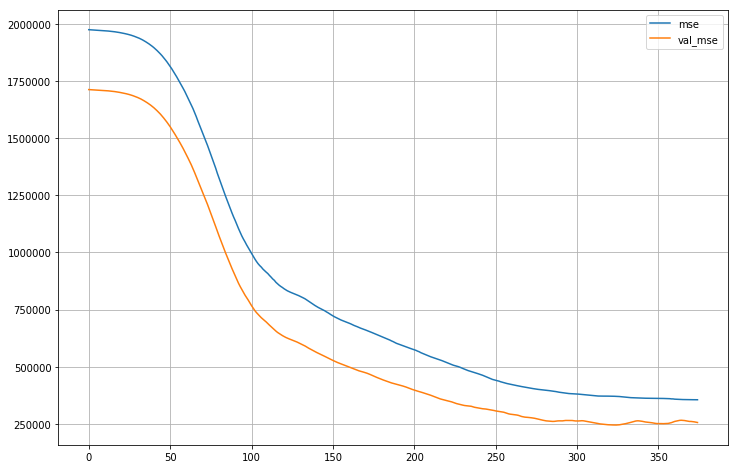

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,8))
# 훈련 데이터의 mse
plt.plot(history.history['mean_squared_error'])
# 검증 데이터의 mse
plt.plot(history.history['val_mean_squared_error'])
plt.legend(['mse','val_mse'])
plt.grid()
plt.show()


In [11]:
import math
# loss, mae, rmse 결과 확인
loss, mae, mse = model.evaluate(testData_features, testData_label, verbose=0)
print(loss, mae, mse)

397457.59375 508.4969177246094 397457.59375


### 예측

In [13]:
test_predictions = model.predict(testData_features).flatten()

# 예측결과 별도 데이터프레임 생성
predictValues = pd.DataFrame(list(test_predictions), columns = ["PREDICT"])

# 예측결과 컬럼 생성
finalResult = pd.concat([testData_all,predictValues],axis=1)
finalResult.head()

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT,HOLIDAY_YN,PROMOTION_YN,PREDICT
0,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201631,2016,31,1522,N,4,Y,0.280258,0,1,1112.765869
1,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201632,2016,32,2100,N,4,Y,0.280258,0,1,1112.765869
2,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201633,2016,33,43,N,4,N,0.000000,0,0,413.527466
3,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201634,2016,34,1700,Y,1,Y,0.308584,1,1,1766.502686
4,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201635,2016,35,1514,Y,1,Y,0.308584,1,1,1766.502686


### 시각화

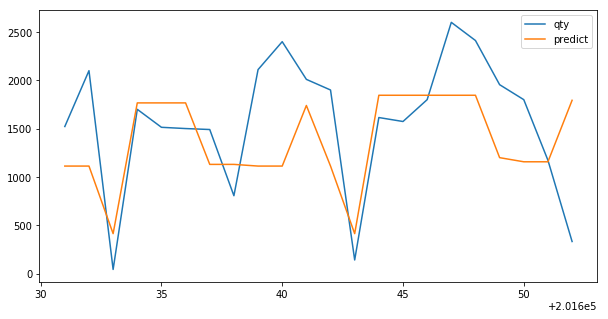

In [14]:
finalResult = finalResult[finalResult.YEARWEEK <= 201652]

import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(10,5))
plt.plot(finalResult["YEARWEEK"], finalResult.QTY, label = "qty")
plt.plot(finalResult["YEARWEEK"], finalResult.PREDICT, label = "predict")
plt.legend(loc=0)

### 모델 저장 및 재학습

In [16]:
# 모델 저장
model_json = model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("linear_keras_sellout.h5")

In [17]:
model.save("linear_keras_sellout2.h5")

In [18]:
from keras.models import model_from_json 
json_file = open("model.json", "r") 
loaded_model_json = json_file.read() 
json_file.close() 

loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("linear_keras_sellout.h5") 

In [19]:
#모델 재 컴파일
optimizer= keras.optimizers.Adam()

loaded_model.compile(loss='mean_squared_error',
                     optimizer=optimizer,
                     metrics=['mean_absolute_error','mean_squared_error'])
loaded_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                320       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


In [20]:

from keras.callbacks import EarlyStopping
#더이상 에러율이 향상되지 않을 시 정지한다, 단 patience 옵션 유지(너무빨리 끝나는거 방지)
early_stopping_monitor = EarlyStopping(patience=50)
EPOCHS = 2000
#모델 훈련 (훈련/검증을 80%, 20%로 나눔)
history =loaded_model.fit(trainingData_features,
                   trainingData_label, 
                   validation_split=0.2, epochs= EPOCHS, callbacks=[early_stopping_monitor])

Train on 66 samples, validate on 17 samples
Epoch 1/2000
66/66 [==============================] - 0s 3ms/step - loss: 356124.8728 - mean_absolute_error: 416.8105 - mean_squared_error: 356124.8728 - val_loss: 259695.4688 - val_mean_absolute_error: 445.1962 - val_mean_squared_error: 259695.4688
Epoch 2/2000
66/66 [==============================] - 0s 83us/step - loss: 355113.8158 - mean_absolute_error: 416.6861 - mean_squared_error: 355113.8158 - val_loss: 261937.3594 - val_mean_absolute_error: 448.6439 - val_mean_squared_error: 261937.3594
Epoch 3/2000
66/66 [==============================] - 0s 120us/step - loss: 354694.2855 - mean_absolute_error: 416.8523 - mean_squared_error: 354694.2855 - val_loss: 261192.0625 - val_mean_absolute_error: 447.5226 - val_mean_squared_error: 261192.0625
Epoch 4/2000
66/66 [==============================] - 0s 90us/step - loss: 354656.6151 - mean_absolute_error: 416.8745 - mean_squared_error: 354656.6151 - val_loss: 262446.3125 - val_mean_absolute_error:

66/66 [==============================] - 0s 113us/step - loss: 349101.7841 - mean_absolute_error: 417.4326 - mean_squared_error: 349101.7841 - val_loss: 281743.6250 - val_mean_absolute_error: 470.5266 - val_mean_squared_error: 281743.6250
Epoch 34/2000
66/66 [==============================] - 0s 98us/step - loss: 349781.6553 - mean_absolute_error: 418.5166 - mean_squared_error: 349781.6553 - val_loss: 287105.2500 - val_mean_absolute_error: 476.5426 - val_mean_squared_error: 287105.2500
Epoch 35/2000
66/66 [==============================] - 0s 75us/step - loss: 349945.6489 - mean_absolute_error: 419.8640 - mean_squared_error: 349945.6489 - val_loss: 292990.7500 - val_mean_absolute_error: 482.8624 - val_mean_squared_error: 292990.7500
Epoch 36/2000
66/66 [==============================] - 0s 120us/step - loss: 350549.9389 - mean_absolute_error: 422.0222 - mean_squared_error: 350549.9389 - val_loss: 297265.0312 - val_mean_absolute_error: 487.2678 - val_mean_squared_error: 297265.0312
Epoc

66/66 [==============================] - 0s 98us/step - loss: 348958.4170 - mean_absolute_error: 421.7645 - mean_squared_error: 348958.4170 - val_loss: 293382.7812 - val_mean_absolute_error: 479.6676 - val_mean_squared_error: 293382.7812
Epoch 66/2000
66/66 [==============================] - 0s 90us/step - loss: 348504.6626 - mean_absolute_error: 421.0519 - mean_squared_error: 348504.6626 - val_loss: 291745.7500 - val_mean_absolute_error: 477.6650 - val_mean_squared_error: 291745.7500
Epoch 67/2000
66/66 [==============================] - 0s 113us/step - loss: 348230.6769 - mean_absolute_error: 420.4113 - mean_squared_error: 348230.6769 - val_loss: 290823.7812 - val_mean_absolute_error: 476.5391 - val_mean_squared_error: 290823.7812
Epoch 68/2000
66/66 [==============================] - 0s 83us/step - loss: 347994.1652 - mean_absolute_error: 419.9963 - mean_squared_error: 347994.1652 - val_loss: 289642.9062 - val_mean_absolute_error: 475.1117 - val_mean_squared_error: 289642.9062
Epoch

In [21]:
test_predictions = model.predict(testData_features).flatten()

# 예측결과 별도 데이터프레임 생성
predictValues = pd.DataFrame(list(test_predictions), columns = ["PREDICT"])

# 예측결과 컬럼 생성
finalResult = pd.concat([testData_all,predictValues],axis=1)
finalResult.head()

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT,HOLIDAY_YN,PROMOTION_YN,PREDICT
0,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201631,2016,31,1522,N,4,Y,0.280258,0,1,1112.765869
1,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201632,2016,32,2100,N,4,Y,0.280258,0,1,1112.765869
2,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201633,2016,33,43,N,4,N,0.000000,0,0,413.527466
3,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201634,2016,34,1700,Y,1,Y,0.308584,1,1,1766.502686
4,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201635,2016,35,1514,Y,1,Y,0.308584,1,1,1766.502686


In [22]:
finalResult = finalResult[finalResult.YEARWEEK <= 201652]

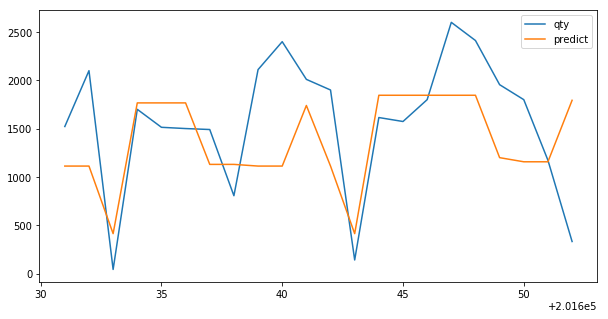

In [23]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(10,5))
plt.plot(finalResult["YEARWEEK"], finalResult.QTY, label = "qty")
plt.plot(finalResult["YEARWEEK"], finalResult.PREDICT, label = "predict")
plt.legend(loc=0)